In [10]:
# torch
import torch
from torchvision.transforms import v2 as T
from torchsummary import summary

# others
import random
import matplotlib.pyplot as plt

# paths
import os
import sys

# set paths
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# my imports
from datasets.voc_subset import VOCSubset
from models.SoSi_detection import SoSiDetectionModel
from utils.plot_utils import plot_images_from_voc_dataset

# the lifesaver
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# torch setup
torch.manual_seed = 42
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## ID calculation
Select backbone based on ID sum:

In [12]:
id1 = '308564293'
id2 = '040830861'

id_sum = sum(int(digit) for digit in (id1 + id2))
id_sum = sum(int(digit) for digit in str(id_sum))
print(f'ID digits sum is: {id_sum}, selecting MobilNet V3.')

ID digits sum is: 7, selecting MobilNet V3.


## P1 - Single Class, Single Instance
In this part we will train a detector for a single class, single instance per image.

### Model Construction
We begin by loading the single object, single instance (sosi) detection model, with the MobilNet V3 Backbone.

In [13]:
# build SoSi Model and send to device
model = SoSiDetectionModel()
model.to(device)
# print the summary
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

### Dataset
Next, we load the `subset` dataset with the single class `cat` and split for train and validation. Since we have only ~1000 images we won't split into 3 (test).

In [14]:
# define the selected class
selected_class_name = "cat"

# load the file containing the indices of images with the selected class
indices_file = os.path.join("..","datasets","indices", f"VOC_{selected_class_name}_selected_indices.pth")
class_idx = torch.load(indices_file)

##### Dataset augmentation
We have ~1084 instances of the selected class `cat`. To better train the model, we would augment them with additional `k` times the dataset length of random images that are not from this class, to add some negative examples.

In [15]:
k = 2
available_idx = set(range(17125)) - set(class_idx)
aug_idx = random.sample(available_idx, min(k * len(class_idx), len(available_idx))) + class_idx
print(f'Total of {len(aug_idx)} samples, of which {len(class_idx)} contain the selected class {selected_class_name}.')

Total of 3252 samples, of which 1084 contain the selected class cat.


#### Transforms
Before bulding the dataset we need to define transformations on the data using `get_trainsform`. 

This function has two modes: train = `True` for training and `False` for validation and inference. In train mode, we will add additional agumentations to enhance the training robustness. 

In inference \ validation, only the basic data transformations from the model backbone defaults are executed.

In [16]:
def get_transform(train, backbone_transforms):
    transforms = []    
    # standard transforms - resizing and center cropping for 1:1 aspect ratio and 224 size
    transforms.append(T.Resize(size = backbone_transforms.resize_size, interpolation = backbone_transforms.interpolation))
    transforms.append(T.CenterCrop(size=backbone_transforms.crop_size))
    
    # if training mode, add flips and jitters
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
    
    # standard transforms - normalizing
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True)) # scale to 0-1
    transforms.append(T.Normalize(mean = backbone_transforms.mean, std = backbone_transforms.std))
    
    return T.Compose(transforms)

### Datasets
Build two datasets, each with the appropriate transformations, split and build dataloader.

In [17]:
# training dataset
train_dataset = VOCSubset(
    indices_list = aug_idx, 
    selected_class = selected_class_name,
    single_instance = True,
    transforms = get_transform(train = True, backbone_transforms = model.backbone_transforms())
)

# validation dataset
val_dataset = VOCSubset(
    indices_list = aug_idx, 
    selected_class = selected_class_name,
    single_instance = True,
    transforms = get_transform(train = False, backbone_transforms = model.backbone_transforms())
)

# split the indices to a train-valid ratio randomly
split_ratio = 0.7
idx = torch.randperm(len(train_dataset)).tolist()
train_size = int(split_ratio * len(idx))

# apply the split to the datasets
train_dataset = torch.utils.data.Subset(train_dataset, idx[:train_size])
val_dataset = torch.utils.data.Subset(val_dataset, idx[train_size:])

print(f'Train dataset of length {len(train_dataset)} and val dataset of length {len(val_dataset)}.')

Train dataset of length 2276 and val dataset of length 976.


#### Test Dataset
We would like to see that the dataset includes these samples and bounding boxes.

AttributeError: 'list' object has no attribute 'squeeze'

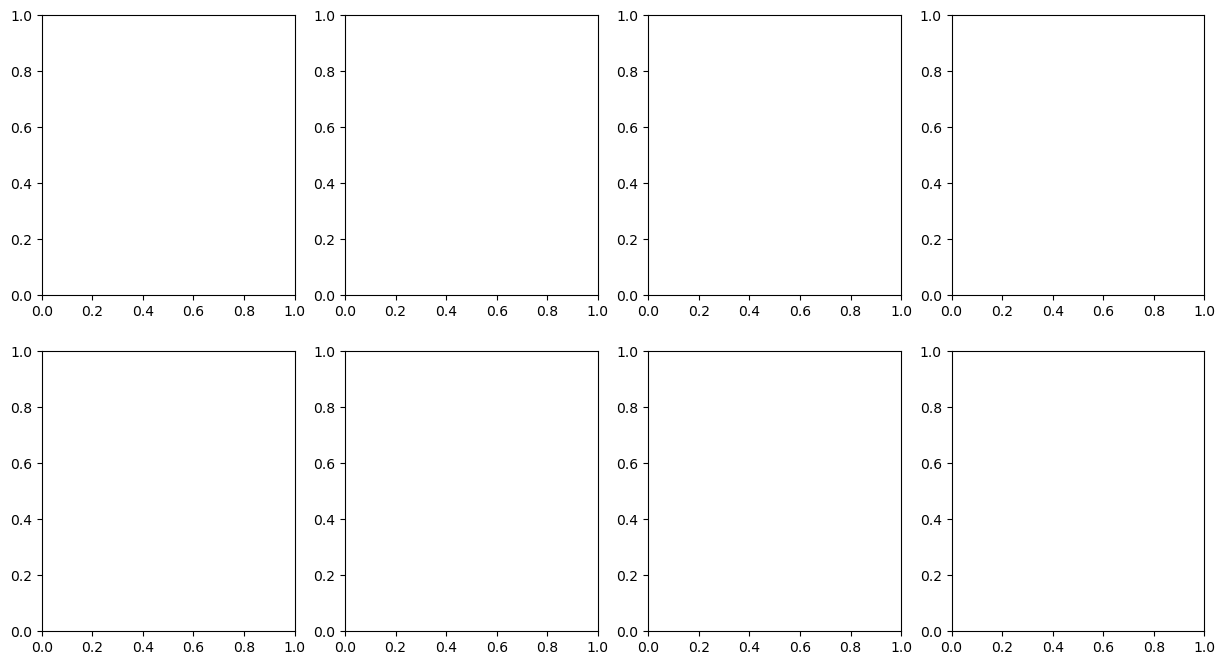

In [27]:
plot_images_from_voc_dataset(train_dataset, num_images=8, title="Train Dataset Samples")
plot_images_from_voc_dataset(val_dataset, num_images=8, title="Validation Dataset Samples")

#### Build data loaders:

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

val_dataloader= torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)